In [267]:
from ucimlrepo import fetch_ucirepo
from mbi import Dataset

import pandas as pd
import numpy as np
import json

# Load data

In [274]:
# fetch dataset 
UCI_adult = fetch_ucirepo(id=2) 

In [286]:
df_UCI_adult = UCI_adult.data.original
df_UCI_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age-shifted
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,22
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,33
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,21
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,36
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,11


In [276]:
file_path = ""
synth_adult = Dataset.load(file_path+'adult.csv', file_path+'adult-domain.json')

df_synth_adult = synth_adult.df
df_synth_adult.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income>50K
0,23,5,4,12,2,8,3,0,1,2,0,39,0,0
1,34,1,4,12,0,4,2,0,1,0,0,12,0,0
2,22,0,13,8,1,6,3,0,1,0,0,39,0,0
3,37,0,15,6,0,6,2,4,1,0,0,39,0,0
4,12,0,22,12,0,5,0,4,0,0,0,39,12,0


# Generate preprocessed files

In [295]:
def generate_preprocessed_adult_files(df_adult,
                                      file_path="test/", 
                                      csv_name="adult.csv", 
                                      json_name="adult-domain.json",
                                      save_files=False):
    # AGE
#     # Change age to decades
#     df_adult["age-decade"] = df_adult["age"].apply(lambda x: x//10)
#     df_adult = df_adult.drop("age", axis=1)
#     # Leave as is but move columns
#     df_adult = df_adult[
#         [col for col in df_adult.columns if col!="age"] + 
#         ["age"]
#     ]
    # Shift down to 0
    df_adult["age-shifted"] = df_adult["age"] - 17
    df_adult = df_adult.drop("age", axis=1)
    
    # WORKCLASS
    def workclass_reducer(workclass):
        if workclass=="Private":
            return "Private"
        elif workclass=="Self-emp-not-inc":
            return "Self-emp-not-inc"
        elif workclass=="Self-emp-inc":
            return "Self-emp-inc"
        elif workclass=="Federal-gov":
            return "Federal-gov"
        elif workclass=="Local-gov" or workclass=="State-gov":
            return "Local-State-gov"
        else:
            return "Other"

    df_adult["workclass-reduced"] = df_adult["workclass"].apply(workclass_reducer)
    df_adult = df_adult.drop("workclass", axis=1)
    
    # FNLWGT
    df_adult = df_adult.drop("fnlwgt", axis=1)
    
    # EDUCATION/EDUCATION-NUM
    df_adult = df_adult.drop("education", axis=1)
    
    def education_num_reducer(education_num):
        if education_num<=6:
            return 0
        elif education_num>=14:
            return 8
        else:
            return int(education_num)-6
#         if education_num<9: # < HS
#             return 1
#         elif education_num==9 or education_num==10: # HS or some college
#             return 2
#         elif education_num==11 or education_num==12: # Associates degree
#             return 3
#         elif education_num==13: # Bachelor's degree
#             return 4
#         elif education_num==14: # Masters degree
#             return 5
#         else: # Professional or doctorate degree
#             return 6
        
    df_adult["education-reduced"] = df_adult["education-num"].apply(education_num_reducer)
    df_adult = df_adult.drop("education-num", axis=1)
    
    # MARITAL-STATUS
    def marital_status_reducer(marital_status):
        if marital_status=="Married-civ-spouse" or marital_status=="Married-AF-spouse": # Married
            return 1
        else: # Not married or separated
            return 0
    
    df_adult["marital-status-reduced"] = df_adult["marital-status"].apply(marital_status_reducer)
    df_adult = df_adult.drop("marital-status", axis=1)
    
    # OCCUPATION
    def occupation_reducer(occupation):
        if pd.isna(occupation):
            return "?"
        else:
            return occupation
    
    df_adult["occupation-reduced"] = df_adult["occupation"].apply(occupation_reducer)
    df_adult = df_adult.drop("occupation", axis=1)
    
    # RELATIONSHIP
#     # Leave as is but move columns
#     df_adult = df_adult[
#         [col for col in df_adult.columns if col!="relationship"] + 
#         ["relationship"]
#     ]
    df_adult["relationship-factorized"] = pd.factorize(df_adult["relationship"])[0]
    df_adult = df_adult.drop("relationship", axis=1)
    
    # RACE - split into privileged vs. non-privileged
    def race_reducer(race):
        if race=="White": # Privileged
            return 1
        else: # Non-privileged
            return 0
    
    df_adult["race-reduced"] = df_adult["race"].apply(race_reducer)
    df_adult = df_adult.drop("race", axis=1)
    
    # SEX (0 for female and 1 for male)
    def sex_reducer(sex):
        if sex=="Male":
            return 1
        else:
            return 0
        
    df_adult["sex-num"] = df_adult["sex"].apply(sex_reducer)
    df_adult = df_adult.drop("sex", axis=1)
    
    # CAPITAL-GAIN
    df_adult["capital-gain-1000s"] = df_adult["capital-gain"]//1000
    df_adult = df_adult.drop("capital-gain", axis=1)
    
    # CAPITAL-LOSS
    df_adult["capital-loss-50s"] = df_adult["capital-loss"]//50
    df_adult = df_adult.drop("capital-loss", axis=1)
    
    # HOURS-PER-WEEK
    # Leave as is but move columns
    df_adult = df_adult[
        [col for col in df_adult.columns if col!="hours-per-week"] + 
        ["hours-per-week"]
    ]
    
    # NATIVE-COUNTRY
    def native_country_reducer(native_country):
        if pd.isna(native_country):
            return "?"
        else:
            return native_country
    
    df_adult["native-country-reduced"] = df_adult["native-country"].apply(native_country_reducer)
    df_adult = df_adult.drop("native-country", axis=1)
    
    # INCOME
    def income_reducer(income):
        if income=="<=50K" or income=="<=50K.":
            return 0
        else:
            return 1
    
    df_adult["income>50K"] = df_adult["income"].apply(income_reducer)
    df_adult = df_adult.drop("income", axis=1)
    
    # Save files
    if save_files:
        df_adult.to_csv(file_path + csv_name, index=False)
        
        adult_domain = {
            "age-shifted": 80,
            "workclass-reduced": 6,
            "education-reduced": 9,
            "marital-status-reduced": 2,
            "occupation-reduced": 15,
            "relationship-factorized": 6,
            "race-reduced": 2,
            "sex-num": 2,
            "capital-gain-1000s": 100,
            "capital-loss-50s": 100,
            "hours-per-week": 99,
            "native-country-reduced": 42,
            "income>50K": 2
        }
        
        with open(file_path + json_name, 'w') as json_file:
            json.dump(adult_domain, json_file)
        
    
    return df_adult

In [296]:
df_UCI_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age-shifted
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,22
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,33
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,21
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,36
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,11


In [297]:
df_preprocessed = generate_preprocessed_adult_files(df_UCI_adult, save_files=True)
df_preprocessed.head()

,age-shifted,workclass-reduced,education-reduced,marital-status-reduced,occupation-reduced,relationship-factorized,race-reduced,sex-num,capital-gain-1000s,capital-loss-50s,hours-per-week,native-country-reduced,income>50K
0,22,Local-State-gov,7,0,Adm-clerical,0,1,1,2,0,40,United-States,0
1,33,Self-emp-not-inc,7,1,Exec-managerial,1,1,1,0,0,13,United-States,0
2,21,Private,3,0,Handlers-cleaners,0,1,1,0,0,40,United-States,0
3,36,Private,1,1,Handlers-cleaners,1,0,1,0,0,40,United-States,0
4,11,Private,7,1,Prof-specialty,2,0,0,0,0,40,Cuba,0


# Experiments with each variable

## Age

Age was apparently converted to the private-pgm format by subtracting by 16 so that the smallest value is 1.

In [84]:
df_UCI_adult.age.value_counts()

36    1348
35    1337
33    1335
23    1329
31    1325
      ... 
88       6
85       5
87       3
89       2
86       1
Name: age, Length: 74, dtype: int64

In [85]:
df_synth_adult.age.value_counts()

20    1348
19    1337
17    1335
7     1329
15    1325
      ... 
72       6
69       5
71       3
73       2
70       1
Name: age, Length: 74, dtype: int64

In [27]:
((df_UCI_adult.age-16)==df_synth_adult.age).all()

True

In [22]:
df_UCI_adult.age.min()

17

In [29]:
df_UCI_adult.age.max()

90

Since my experiments have shown that breaking into decades does not significantly impact performance, I could also break into decades as follows.

In [36]:
(df_UCI_adult.age//10).value_counts()

3    12929
2    12005
4    10724
5     6619
6     3054
1     2510
7      815
8      131
9       55
Name: age, dtype: int64

## Workclass

In [53]:
df_UCI_adult.workclass.value_counts(dropna=False)

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
NaN                   963
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [42]:
df_synth_adult.workclass.value_counts()

0    33906
1     3862
4     3136
8     2799
5     1981
2     1695
3     1432
6       21
7       10
Name: workclass, dtype: int64

In [54]:
# Private
df_synth_adult[df_synth_adult.workclass==0]["income>50K"].mean()

0.21786704418097091

In [55]:
# Self-emp-not-inc
df_synth_adult[df_synth_adult.workclass==1]["income>50K"].mean()

0.27887105126877265

In [56]:
# Self-emp-inc
df_synth_adult[df_synth_adult.workclass==2]["income>50K"].mean()

0.5533923303834808

In [57]:
# Federal-gov
df_synth_adult[df_synth_adult.workclass==3]["income>50K"].mean()

0.39175977653631283

In [59]:
# Local-gov
df_synth_adult[df_synth_adult.workclass==4]["income>50K"].mean()

0.2955994897959184

In [58]:
# State-gov
df_synth_adult[df_synth_adult.workclass==5]["income>50K"].mean()

0.2675416456335184

In [60]:
# Without-pay
df_synth_adult[df_synth_adult.workclass==6]["income>50K"].mean()

0.09523809523809523

In [61]:
# Never-worked
df_synth_adult[df_synth_adult.workclass==7]["income>50K"].mean()

0.0

In [62]:
# ?
df_synth_adult[df_synth_adult.workclass==8]["income>50K"].mean()

0.09467667023937121

Several ways to break this down. My current plan is to do 6 categories (private, self-emp-not-inc, self-emp-inc, federal-gov, state-local-gov, other).

## Fnlwgt

In [160]:
df_UCI_adult.fnlwgt.value_counts()

203488    21
120277    19
190290    19
125892    18
126569    18
          ..
286983     1
185942     1
234220     1
214706     1
350977     1
Name: fnlwgt, Length: 28523, dtype: int64

In [68]:
df_synth_adult.fnlwgt.value_counts()

11    4162
12    3899
10    3394
6     3014
7     2940
      ... 
65       1
61       1
98       1
99       1
80       1
Name: fnlwgt, Length: 77, dtype: int64

Not sure what is going on with this column. I will just drop it...

## Education/education-num

In [81]:
df_UCI_adult.education.value_counts()

HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64

In [83]:
df_UCI_adult["education-num"].value_counts()

9     15784
10    10878
13     8025
14     2657
11     2061
7      1812
12     1601
6      1389
4       955
15      834
5       756
8       657
16      594
3       509
2       247
1        83
Name: education-num, dtype: int64

In [82]:
df_synth_adult["education-num"].value_counts()

8     15784
9     10878
12     8025
13     2657
10     2061
6      1812
11     1601
5      1389
3       955
14      834
4       756
7       657
15      594
2       509
1       247
0        83
Name: education-num, dtype: int64

In [92]:
df_synth_adult.groupby("education-num")["income>50K"].mean()

education-num
0     0.012048
1     0.032389
2     0.053045
3     0.064921
4     0.054233
5     0.062635
6     0.050773
7     0.073059
8     0.158578
9     0.189649
10    0.253275
11    0.257964
12    0.412835
13    0.549116
14    0.739808
15    0.725589
Name: income>50K, dtype: float64

It appears all three of these columns give the same information, except that the one used in the private-pgm code subtracts 1 from each value. I will just keep it as is and drop the non-numeric education column.

## Marital-status

In [90]:
df_UCI_adult["marital-status"].value_counts()

Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: marital-status, dtype: int64

In [91]:
df_synth_adult["marital-status"].value_counts()

0    22379
2    16117
1     6633
3     1530
4     1518
5      628
6       37
Name: marital-status, dtype: int64

In [97]:
df_synth_adult.groupby("marital-status")["income>50K"].mean()

marital-status
0    0.446133
1    0.101161
2    0.045480
3    0.064706
4    0.084321
5    0.092357
6    0.378378
Name: income>50K, dtype: float64

## Occupation

In [103]:
df_UCI_adult.occupation.value_counts(dropna=False)

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
?                    1843
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
NaN                   966
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

In [104]:
df_synth_adult.occupation.value_counts()

5     6172
1     6112
4     6086
8     5611
3     5504
2     4923
7     3022
14    2809
10    2355
6     2072
9     1490
0     1446
12     983
11     242
13      15
Name: occupation, dtype: int64

In [105]:
df_synth_adult.groupby("occupation")["income>50K"].mean()

occupation
0     0.290456
1     0.226276
2     0.041438
3     0.267987
4     0.477818
5     0.451069
6     0.066602
7     0.123097
8     0.136874
9     0.116107
10    0.204246
11    0.012397
12    0.313327
13    0.333333
14    0.094340
Name: income>50K, dtype: float64

Not sure how to reduce the count of these. I'll just convert NaNs and ?'s to Other for now.

## Relationship

In [138]:
df_UCI_adult.relationship.value_counts()

Husband           19716
Not-in-family     12583
Own-child          7581
Unmarried          5125
Wife               2331
Other-relative     1506
Name: relationship, dtype: int64

In [291]:
pd.factorize(df_UCI_adult.relationship)

(array([0, 1, 0, ..., 1, 3, 1]),
 Index(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
        'Other-relative'],
       dtype='object'))

In [139]:
df_synth_adult.relationship.value_counts()

2    19716
3    12583
1     7581
5     5125
0     2331
4     1506
Name: relationship, dtype: int64

In [140]:
df_synth_adult.groupby("relationship")["income>50K"].mean()

relationship
0    0.468897
1    0.014642
2    0.448671
3    0.101407
4    0.034529
5    0.060293
Name: income>50K, dtype: float64

All of these seem independently interesting and without a clear way to reduce to groups. I'll keep as is.

## Race

In [141]:
df_UCI_adult.race.value_counts()

White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: race, dtype: int64

In [142]:
df_synth_adult.race.value_counts()

0    41762
4     4685
1     1519
2      470
3      406
Name: race, dtype: int64

In [148]:
df_synth_adult.groupby("race")["income>50K"].mean()

race
0    0.253987
1    0.269256
2    0.117021
3    0.123153
4    0.120811
Name: income>50K, dtype: float64

For now, I'll split this into privileged (white) and non-privileged (everyone else).

## Sex

In [145]:
df_UCI_adult.sex.value_counts()

Male      32650
Female    16192
Name: sex, dtype: int64

In [146]:
df_synth_adult.sex.value_counts()

1    32650
0    16192
Name: sex, dtype: int64

In [147]:
df_synth_adult.groupby("sex")["income>50K"].mean()

sex
0    0.109251
1    0.303767
Name: income>50K, dtype: float64

I'll leave this one as is for now.

## Capital-gain

In [156]:
(df_UCI_adult["capital-gain"]//1000).value_counts()

0     44888
7       803
15      531
3       504
2       473
4       379
5       296
99      244
1       147
6       100
10       91
14       83
8        82
27       58
20       49
13       42
9        36
25       20
34        6
11        4
41        3
18        2
22        1
Name: capital-gain, dtype: int64

In [150]:
df_synth_adult["capital-gain"].value_counts()

0     44888
7       803
15      531
3       504
2       473
4       379
5       296
99      244
1       147
6       100
10       91
14       83
8        82
27       58
20       49
13       42
9        36
25       20
34        6
11        4
41        3
18        2
22        1
Name: capital-gain, dtype: int64

In [184]:
((df_UCI_adult["capital-gain"]//1000)==df_synth_adult["capital-gain"]).all()

True

This is the previously used mapping so I will stick with it.

## Capital-loss

In [177]:
(df_UCI_adult["capital-loss"]//50).value_counts()

0     46560
39      317
38      308
37      293
34      180
31      156
33      105
32      100
48       92
40       80
36       79
29       71
41       46
44       45
45       44
28       43
47       38
43       32
30       30
46       27
35       22
12       17
51       17
56       14
42       12
49       12
26       11
21       11
27       10
52        7
25        6
17        6
6         5
60        5
4         5
50        5
75        4
22        4
13        4
87        3
8         3
19        2
16        2
73        2
78        2
55        2
63        2
3         1
Name: capital-loss, dtype: int64

In [178]:
df_synth_adult["capital-loss"].value_counts()

0     46560
39      317
38      308
37      293
34      180
31      156
33      105
32      100
48       92
40       80
36       79
29       71
41       46
44       45
45       44
28       43
47       38
43       32
30       30
46       27
35       22
12       17
51       17
56       14
42       12
49       12
26       11
21       11
27       10
52        7
25        6
17        6
6         5
60        5
4         5
50        5
75        4
22        4
13        4
87        3
8         3
19        2
16        2
73        2
77        2
55        2
63        2
3         1
Name: capital-loss, dtype: int64

In [182]:
((df_UCI_adult["capital-loss"]//50)!=df_synth_adult["capital-loss"]).sum()

2

This is basically right, so I'll just go with it. I may split into fewer groups further down the line.

## Hours-per-week

In [189]:
df_UCI_adult["hours-per-week"].value_counts()

40    22803
50     4246
45     2717
60     2177
35     1937
      ...  
79        1
94        1
82        1
87        1
69        1
Name: hours-per-week, Length: 96, dtype: int64

In [190]:
df_synth_adult["hours-per-week"].value_counts()

39    22803
49     4246
44     2717
59     2177
34     1937
      ...  
78        1
93        1
81        1
86        1
68        1
Name: hours-per-week, Length: 96, dtype: int64

In [191]:
((df_UCI_adult["hours-per-week"]-1)==df_synth_adult["hours-per-week"]).all()

True

<Axes: >

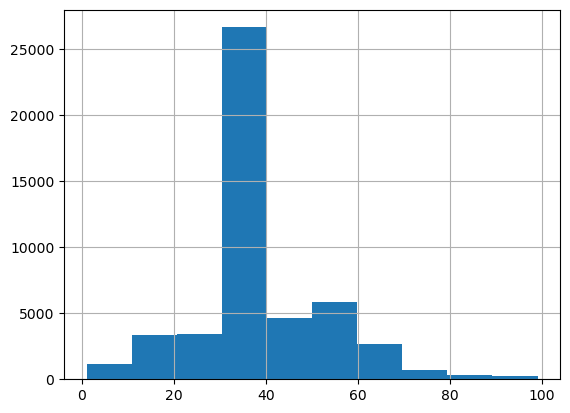

In [194]:
df_UCI_adult["hours-per-week"].hist()

I'll just use the original numbering without subtracting 1. I may further reduce this later though.

## Native-country

In [197]:
df_UCI_adult["native-country"].value_counts(dropna=False)

United-States                 43832
Mexico                          951
?                               583
Philippines                     295
NaN                             274
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                   

In [196]:
df_synth_adult["native-country"].value_counts()

0     43832
20      951
41      857
15      295
5       206
3       184
4       182
36      155
7       151
12      138
2       127
11      122
10      115
18      106
16      105
24      103
8        92
31       88
17       87
19       86
29       85
28       75
21       67
27       65
13       59
9        49
32       49
38       46
26       45
23       38
22       37
39       30
34       30
1        28
37       27
25       23
35       23
6        23
33       21
14       20
30       19
40        1
Name: native-country, dtype: int64

I'll leave this one as is for now except changing NaNs to ? but I may try to reduce it later if it ends up being useful for the model.

## Income

In [202]:
df_UCI_adult.income.value_counts(dropna=False)

<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: income, dtype: int64

In [203]:
df_synth_adult["income>50K"].value_counts()

0    37155
1    11687
Name: income>50K, dtype: int64